In [1]:
import os
os.environ["TORCH_COMPILE_DISABLE"] = "1"
os.environ["TORCHDYNAMO_DISABLE"] = "1"


In [4]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [5]:
BASE_PATH = "/kaggle/input/c2ty2bcoulouredspurious/colored_mnist/type2_background"
EASY_PATH = os.path.join(BASE_PATH, "easy_train")
HARD_PATH = os.path.join(BASE_PATH, "hard_test")

transform = transforms.ToTensor()

easy_full = datasets.ImageFolder(EASY_PATH, transform=transform)
hard_full = datasets.ImageFolder(HARD_PATH, transform=transform)



In [6]:
def stratified_subset(dataset, fraction):
    targets = np.array(dataset.targets)
    indices = np.arange(len(targets))

    sss = StratifiedShuffleSplit(
        n_splits=1,
        test_size=fraction,
        random_state=42
    )

    _, subset_idx = next(sss.split(indices, targets))
    return Subset(dataset, subset_idx)


In [7]:
FRACTION = 0.25

easy_subset = stratified_subset(easy_full, FRACTION)
hard_subset = stratified_subset(hard_full, FRACTION)

print("\nAfter subset")
print("Easy Subset :", len(easy_subset))
print("Hard Subset :", len(hard_subset))



After subset
Easy Subset : 15000
Hard Subset : 2500


In [8]:
easy_targets = np.array([easy_full.targets[i] for i in easy_subset.indices])
indices = np.arange(len(easy_targets))

sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)

train_idx, val_idx = next(sss.split(indices, easy_targets))

easy_train = Subset(easy_subset, train_idx)
easy_val   = Subset(easy_subset, val_idx)

print("\nFinal splits")
print("Easy Train :", len(easy_train))
print("Easy Val   :", len(easy_val))



Final splits
Easy Train : 12000
Easy Val   : 3000


In [9]:
def class_counts(dataset):
    counts = {i: 0 for i in range(10)}
    for _, y in dataset:
        counts[y] += 1
    return counts


print("\n Class distribution (Train)")
print(class_counts(easy_train))

print("\n Class distribution (Val)")
print(class_counts(easy_val))

print("\n Class distribution (Hard Test)")
print(class_counts(hard_subset))


 Class distribution (Train)
{0: 1185, 1: 1349, 2: 1191, 3: 1226, 4: 1169, 5: 1084, 6: 1183, 7: 1253, 8: 1170, 9: 1190}

 Class distribution (Val)
{0: 296, 1: 337, 2: 298, 3: 307, 4: 292, 5: 271, 6: 296, 7: 313, 8: 293, 9: 297}

 Class distribution (Hard Test)
{0: 245, 1: 284, 2: 258, 3: 253, 4: 245, 5: 223, 6: 240, 7: 257, 8: 243, 9: 252}


In [10]:
BATCH_SIZE = 64

train_loader = DataLoader(
    easy_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

val_loader = DataLoader(
    easy_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

hard_loader = DataLoader(
    hard_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

print("\nDataLoaders ready")
print("Train batches:", len(train_loader))
print("Val batches  :", len(val_loader))
print("Hard batches :", len(hard_loader))



DataLoaders ready
Train batches: 188
Val batches  : 47
Hard batches : 40


In [11]:
import torch.nn.functional as F

class RobustCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 28 -> 14
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 14 -> 7
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.fc = nn.Linear(128 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


In [20]:
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()

model = RobustCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 20
EARLY_STOP_DELTA = 0.01

# history buffers
epochs_hist = []
train_loss_hist = []
val_loss_hist = []

prev_val_loss = None

for epoch in range(EPOCHS):

    # -------- TRAIN --------
    model.train()
    train_loss_sum = 0.0
    train_correct = 0
    train_total = 0

    for x, y in tqdm(
        train_loader,
        desc=f"Epoch {epoch+1:02d} TRAIN (BatchNorm only)"
    ):
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        preds = logits.argmax(1)
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_loss = train_loss_sum / len(train_loader)
    train_acc = 100.0 * train_correct / train_total

    # -------- VALIDATION --------
    model.eval()
    val_loss_sum = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for x, y in tqdm(
            val_loader,
            desc=f"Epoch {epoch+1:02d} VAL"
        ):
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            val_loss_sum += loss.item()
            preds = logits.argmax(1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_loss = val_loss_sum / len(val_loader)
    val_acc = 100.0 * val_correct / val_total

    # log
    epochs_hist.append(epoch + 1)
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Train Acc: {train_acc:.2f}% | "
        f"Val Acc: {val_acc:.2f}%"
    )

    # -------- EARLY STOP --------
    if prev_val_loss is not None and abs(prev_val_loss - val_loss) < EARLY_STOP_DELTA:
        print("Early stopping triggered")
        break

    prev_val_loss = val_loss


Epoch 01 VAL: 100%|██████████| 47/47 [00:01<00:00, 26.31it/s]


Epoch 01 | Train Loss: 0.2361 | Val Loss: 0.1268 | Train Acc: 95.08% | Val Acc: 96.70%


Epoch 02 VAL: 100%|██████████| 47/47 [00:01<00:00, 30.90it/s]


Epoch 02 | Train Loss: 0.0835 | Val Loss: 0.1134 | Train Acc: 97.77% | Val Acc: 96.80%


Epoch 03 VAL: 100%|██████████| 47/47 [00:01<00:00, 31.76it/s]


Epoch 03 | Train Loss: 0.0507 | Val Loss: 0.0972 | Train Acc: 98.55% | Val Acc: 97.20%


Epoch 04 VAL: 100%|██████████| 47/47 [00:01<00:00, 31.98it/s]


Epoch 04 | Train Loss: 0.0426 | Val Loss: 0.0713 | Train Acc: 98.71% | Val Acc: 97.77%


Epoch 05 VAL: 100%|██████████| 47/47 [00:01<00:00, 29.03it/s]


Epoch 05 | Train Loss: 0.0344 | Val Loss: 0.0980 | Train Acc: 99.03% | Val Acc: 97.87%


Epoch 06 VAL: 100%|██████████| 47/47 [00:01<00:00, 32.94it/s]

Epoch 06 | Train Loss: 0.0182 | Val Loss: 0.0906 | Train Acc: 99.38% | Val Acc: 98.27%
Early stopping triggered


In [21]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in hard_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

hard_acc = 100.0 * correct / total
print("Hard Test Accuracy:", hard_acc)


Hard Test Accuracy: 80.84


In [22]:
def color_gradient_penalty(images, logits, labels):
    ce_loss = criterion(logits, labels)

    grads = torch.autograd.grad(
        outputs=logits.gather(1, labels.view(-1, 1)).sum(),
        inputs=images,
        create_graph=True
    )[0]

    grad_r = grads[:, 0]
    grad_g = grads[:, 1]
    grad_b = grads[:, 2]

    color_penalty = torch.var(
        torch.stack([grad_r, grad_g, grad_b], dim=1),
        dim=1
    ).mean()

    return ce_loss, color_penalty


In [23]:
criterion = nn.CrossEntropyLoss()

model = RobustCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 20
LAMBDA_MAX = 10.0
EARLY_STOP_DELTA = 0.001

def lambda_schedule(epoch):
    return LAMBDA_MAX * (epoch / EPOCHS)


In [24]:
def color_gradient_penalty(images, logits, labels):
    ce_loss = criterion(logits, labels)

    grads = torch.autograd.grad(
        outputs=logits.gather(1, labels.view(-1, 1)).sum(),
        inputs=images,
        create_graph=True
    )[0]

    grad_r = grads[:, 0]
    grad_g = grads[:, 1]
    grad_b = grads[:, 2]

    color_penalty = torch.var(
        torch.stack([grad_r, grad_g, grad_b], dim=1),
        dim=1
    ).mean()

    return ce_loss, color_penalty


In [25]:
from tqdm import tqdm

# history buffers
epochs_hist = []
lambda_hist = []
train_loss_hist = []
val_loss_hist = []

prev_val_loss = None

for epoch in range(EPOCHS):

    lam = lambda_schedule(epoch)

    # -------- TRAIN --------
    model.train()
    train_loss_sum = 0.0
    train_correct = 0
    train_total = 0

    for x, y in tqdm(
        train_loader,
        desc=f"Epoch {epoch+1:02d} TRAIN λ={lam:.2f}"
    ):
        x, y = x.to(device), y.to(device)
        x.requires_grad_(True)

        logits = model(x)
        ce_loss, color_pen = color_gradient_penalty(x, logits, y)
        loss = ce_loss + lam * color_pen

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        preds = logits.argmax(1)
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_loss = train_loss_sum / len(train_loader)
    train_acc = 100.0 * train_correct / train_total

    # -------- VALIDATION --------
    model.eval()
    val_loss_sum = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for x, y in tqdm(
            val_loader,
            desc=f"Epoch {epoch+1:02d} VAL"
        ):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            val_loss_sum += loss.item()
            preds = logits.argmax(1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_loss = val_loss_sum / len(val_loader)
    val_acc = 100.0 * val_correct / val_total

    # log
    epochs_hist.append(epoch + 1)
    lambda_hist.append(lam)
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Train Acc: {train_acc:.2f}% | "
        f"Val Acc: {val_acc:.2f}%"
    )

    if prev_val_loss is not None and abs(prev_val_loss - val_loss) < EARLY_STOP_DELTA:
        print("Early stopping triggered")
        break

    prev_val_loss = val_loss


Epoch 01 VAL: 100%|██████████| 47/47 [00:01<00:00, 32.22it/s]


Epoch 01 | Train Loss: 0.2469 | Val Loss: 0.1509 | Train Acc: 94.88% | Val Acc: 96.77%


Epoch 02 VAL: 100%|██████████| 47/47 [00:01<00:00, 30.63it/s]


Epoch 02 | Train Loss: 0.1010 | Val Loss: 0.1186 | Train Acc: 97.62% | Val Acc: 96.40%


Epoch 03 VAL: 100%|██████████| 47/47 [00:01<00:00, 30.80it/s]


Epoch 03 | Train Loss: 0.0617 | Val Loss: 0.1043 | Train Acc: 98.36% | Val Acc: 97.43%


Epoch 04 VAL: 100%|██████████| 47/47 [00:01<00:00, 32.42it/s]


Epoch 04 | Train Loss: 0.0429 | Val Loss: 0.0563 | Train Acc: 98.96% | Val Acc: 98.43%


Epoch 05 VAL: 100%|██████████| 47/47 [00:01<00:00, 33.15it/s]


Epoch 05 | Train Loss: 0.0396 | Val Loss: 0.0452 | Train Acc: 99.24% | Val Acc: 98.60%


Epoch 06 VAL: 100%|██████████| 47/47 [00:01<00:00, 28.63it/s]


Epoch 06 | Train Loss: 0.0356 | Val Loss: 0.0414 | Train Acc: 99.32% | Val Acc: 98.67%


Epoch 07 VAL: 100%|██████████| 47/47 [00:02<00:00, 21.29it/s]


Epoch 07 | Train Loss: 0.0291 | Val Loss: 0.0402 | Train Acc: 99.47% | Val Acc: 98.57%


Epoch 08 VAL: 100%|██████████| 47/47 [00:02<00:00, 22.30it/s]


Epoch 08 | Train Loss: 0.0200 | Val Loss: 0.0451 | Train Acc: 99.78% | Val Acc: 98.67%


Epoch 09 VAL: 100%|██████████| 47/47 [00:02<00:00, 20.68it/s]


Epoch 09 | Train Loss: 0.0191 | Val Loss: 0.0424 | Train Acc: 99.77% | Val Acc: 98.77%


Epoch 10 VAL: 100%|██████████| 47/47 [00:02<00:00, 20.06it/s]


Epoch 10 | Train Loss: 0.0177 | Val Loss: 0.0576 | Train Acc: 99.75% | Val Acc: 98.50%


Epoch 11 VAL: 100%|██████████| 47/47 [00:02<00:00, 19.86it/s]


Epoch 11 | Train Loss: 0.0279 | Val Loss: 0.0716 | Train Acc: 99.50% | Val Acc: 98.10%


Epoch 12 VAL: 100%|██████████| 47/47 [00:02<00:00, 21.98it/s]


Epoch 12 | Train Loss: 0.0379 | Val Loss: 0.0571 | Train Acc: 99.19% | Val Acc: 98.53%


Epoch 13 VAL: 100%|██████████| 47/47 [00:02<00:00, 23.04it/s]


Epoch 13 | Train Loss: 0.0366 | Val Loss: 0.0350 | Train Acc: 99.33% | Val Acc: 98.93%


Epoch 14 VAL: 100%|██████████| 47/47 [00:01<00:00, 31.70it/s]

Epoch 14 | Train Loss: 0.0176 | Val Loss: 0.0341 | Train Acc: 99.79% | Val Acc: 98.93%
Early stopping triggered


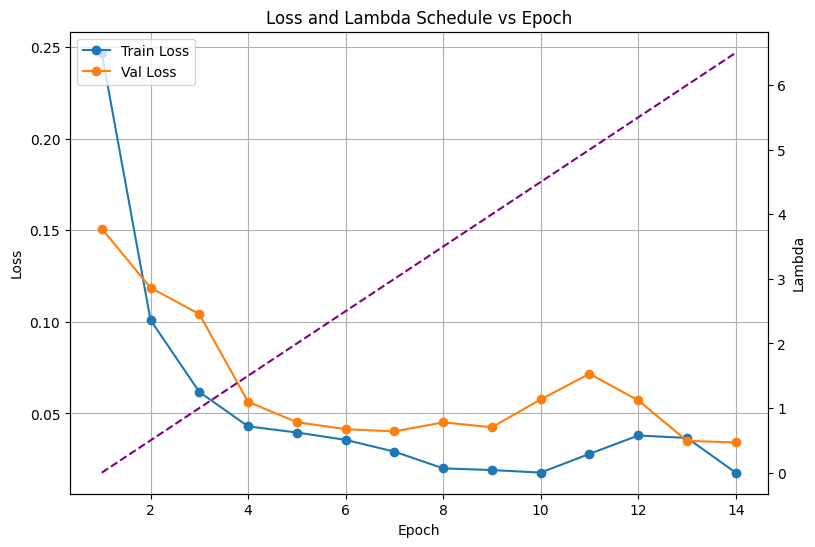

In [26]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(9, 6))

ax1.plot(epochs_hist, train_loss_hist, label="Train Loss", marker="o")
ax1.plot(epochs_hist, val_loss_hist, label="Val Loss", marker="o")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(epochs_hist, lambda_hist, label="Lambda", color="purple", linestyle="--")
ax2.set_ylabel("Lambda")

plt.title("Loss and Lambda Schedule vs Epoch")
plt.show()


In [27]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in hard_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

hard_acc = 100.0 * correct / total
print("Hard Test Accuracy:", hard_acc)


Hard Test Accuracy: 83.76


In [28]:
MODEL_PATH = "/kaggle/working/task4final_robust_colored_mnist.pth"
torch.save(model.state_dict(), MODEL_PATH)

print(" Task-4 robust model saved")
print(" Path:", MODEL_PATH)


 Task-4 robust model saved
 Path: /kaggle/working/task4final_robust_colored_mnist.pth


In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model.eval()

# ---------- Easy Validation ----------
correct, total = 0, 0
y_val_true, y_val_pred = [], []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        y_val_true.extend(y.cpu().numpy())
        y_val_pred.extend(preds.cpu().numpy())

easy_val_acc = 100 * correct / total
print(f" Easy Validation Accuracy: {easy_val_acc:.2f}%")

# ---------- Hard Test ----------
correct, total = 0, 0
y_hard_true, y_hard_pred = [], []

with torch.no_grad():
    for x, y in hard_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        y_hard_true.extend(y.cpu().numpy())
        y_hard_pred.extend(preds.cpu().numpy())

hard_acc = 100 * correct / total
print(f" Hard Test Accuracy (Task-4_BatchNorm+colorpenality:): {hard_acc:.2f}%")


 Easy Validation Accuracy: 98.93%
 Hard Test Accuracy (Task-4_BatchNorm+colorpenality:): 83.76%


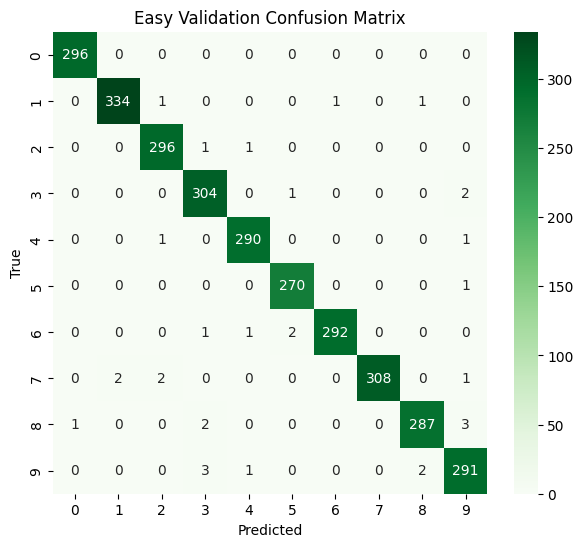

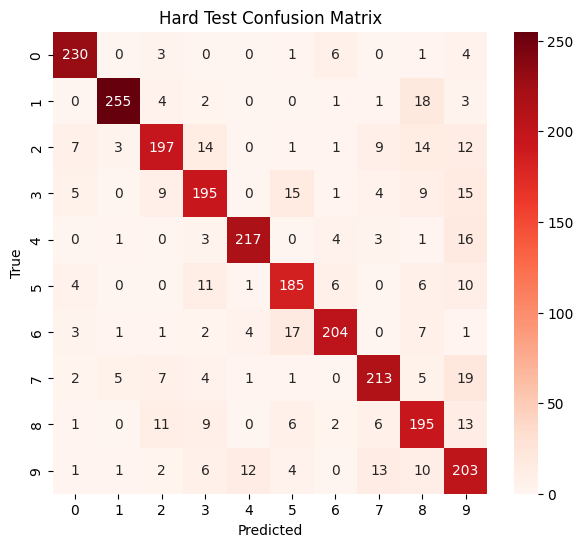

In [31]:
# Easy Validation CM
cm_easy = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm_easy, annot=True, fmt="d", cmap="Greens")
plt.title("Easy Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Hard Test CM
cm_hard = confusion_matrix(y_hard_true, y_hard_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm_hard, annot=True, fmt="d", cmap="Reds")
plt.title("Hard Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [32]:
DIGIT_TO_COLOR = {
    0: (np.array([255,   0,   0]), "Red"),
    1: (np.array([  0, 255,   0]), "Green"),
    2: (np.array([  0,   0, 255]), "Blue"),
    3: (np.array([255, 255,   0]), "Yellow"),
    4: (np.array([128,   0, 128]), "Purple"),
    5: (np.array([255, 165,   0]), "Orange"),
    6: (np.array([  0, 255, 255]), "Cyan"),
    7: (np.array([255,   0, 255]), "Magenta"),
    8: (np.array([165,  42,  42]), "Brown"),
    9: (np.array([255, 192, 203]), "Pink")
}

def nearest_color(mean_rgb):
    return min(
        DIGIT_TO_COLOR.keys(),
        key=lambda k: np.linalg.norm(mean_rgb - DIGIT_TO_COLOR[k][0])
    )

color_pred_matrix = np.zeros((10, 10), dtype=int)

model.eval()
with torch.no_grad():
    for imgs, _ in hard_loader:
        imgs = imgs.to(device)
        preds = model(imgs).argmax(1).cpu().numpy()

        imgs_np = imgs.cpu().numpy().transpose(0, 2, 3, 1) * 255

        for i in range(len(preds)):
            mean_rgb = imgs_np[i].mean(axis=(0, 1))
            color_id = nearest_color(mean_rgb.astype(int))
            color_pred_matrix[color_id, preds[i]] += 1

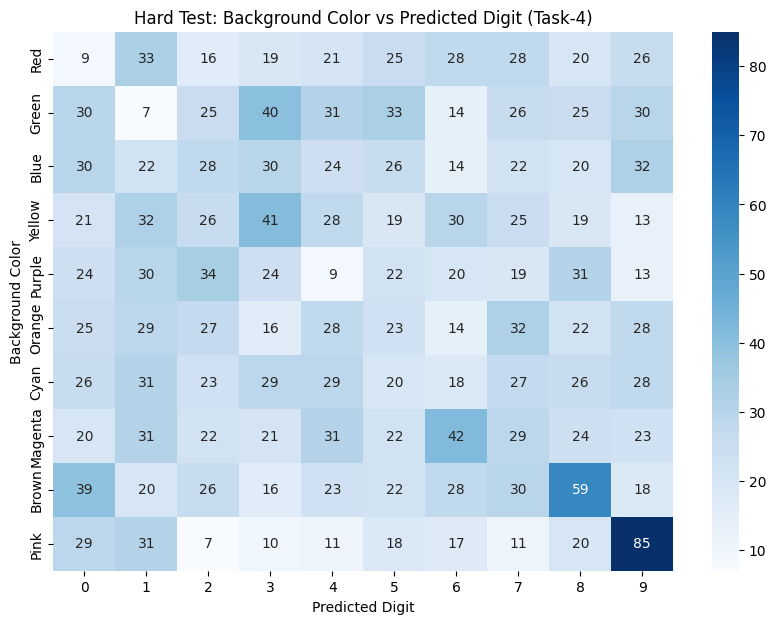

In [33]:
color_names = [DIGIT_TO_COLOR[i][1] for i in range(10)]
digit_labels = [str(i) for i in range(10)]

plt.figure(figsize=(10,7))
sns.heatmap(
    color_pred_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=digit_labels,
    yticklabels=color_names
)
plt.xlabel("Predicted Digit")
plt.ylabel("Background Color")
plt.title("Hard Test: Background Color vs Predicted Digit (Task-4)")
plt.show()


In [34]:
total_ones, correct_ones = 0, 0

with torch.no_grad():
    for x, y in hard_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)

        mask = (y == 1)
        total_ones += mask.sum().item()
        correct_ones += (preds[mask] == 1).sum().item()

percentage = 100 * correct_ones / total_ones
print("===== HARD TEST: DIGIT 1 =====")
print(f"Total digit-1 samples : {total_ones}")
print(f"Correct predictions   : {correct_ones}")
print(f"Accuracy              : {percentage:.2f}%")


===== HARD TEST: DIGIT 1 =====
Total digit-1 samples : 284
Correct predictions   : 255
Accuracy              : 89.79%
